### **Deep Learning - Proyecto Final**

Stefano Aragoni, Carol Arévalo

----------

##### **Introducción**
El cyberbullying es una forma de acoso que se lleva a cabo a través de medios electrónicos, como las redes sociales. Este se caracteriza por ser –en su mayoría de instancias– anónimo y por la facilidad con la que los agresores pueden unirse y atacar a las víctimas. Es un problema grave que puede tener consecuencias emocionales y psicológicas significativas para quienes lo sufren. En realidad, según varios estudios, los adolescentes víctimas de ciberacoso son 4 veces más probables a tener pensamientos suicidas a comparación de aquellos que no reciben este tipo de acoso

En el presente trabajo se busca afrontar la problemática de ciberacoso en redes sociales a través de deep learning. Esto con el propósito de poder ayudar a la salud mental de aquellas personas que son víctimas de este tipo de violencia.

--------

Como primer paso, se **importaron las librerías necesarias** para el análisis exploratorio y el preprocesamiento de los datos.



In [70]:
# Importaciones de bibliotecas estándar
import numpy as np
import pandas as pd
import re
from collections import Counter
from copy import deepcopy
from tqdm import tqdm

# Importaciones de visualización
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from prettytable import PrettyTable

# Importaciones de procesamiento de texto y NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')

# Importaciones de aprendizaje automático y ciencia de datos
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.optimizers import SGD

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import (
    train_test_split,
)
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report
)

# Otras importaciones
from tqdm import tqdm
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stefanoaragoni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### **Análisis Exploratorio**

Para este proyecto, se utilizó un dataset presentado en la ‘Conferencia Internacional de Big Data’ en el 2020. Esta almacena tweets junto con una clasificación de los mismos para indicar si estos representan ciberacoso o no. A partir de esta base de datos, se realizó un análisis exploratorio. 

Primero, se **cargó el dataset** y se visualizaron las primeras 5 filas para tener una idea de la estructura de los datos.

Como se puede observar, el dataset cuenta con 2 columnas: 'tweet_text' y 'cyberbullying_type'. La primera almacena el texto del tweet y la segunda indica si este representa ciberacoso o no.

In [71]:
#cargar dataset
data = pd.read_csv('cyberbullying_tweets_clean.csv')

# Imprimir las primeras 5 filas
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


Con eso listo, se procedió a **visualizar la cantidad de tweets que representan ciberacoso y los que no**. 


Como se puede observar a continuación, pareciera que el dataset está balanceado. Esto debido a que cada clase cuenta con una cantidad similar de tweets. 

Sin embargo, religion, age, gender, ethnicity combinados representan el 80% de los tweets. Por tal motivo, al verlo como dos clases (cyberbullying y no cyberbullying) se puede observar que el dataset está desbalanceado. Esto debido a que la clase cyberbullying representa el 80% de los tweets, mientras que la clase no cyberbullying representa el 20% de los tweets.

cyberbullying_type
religion             7998
age                  7992
gender               7973
ethnicity            7961
not_cyberbullying    7945
Name: count, dtype: int64


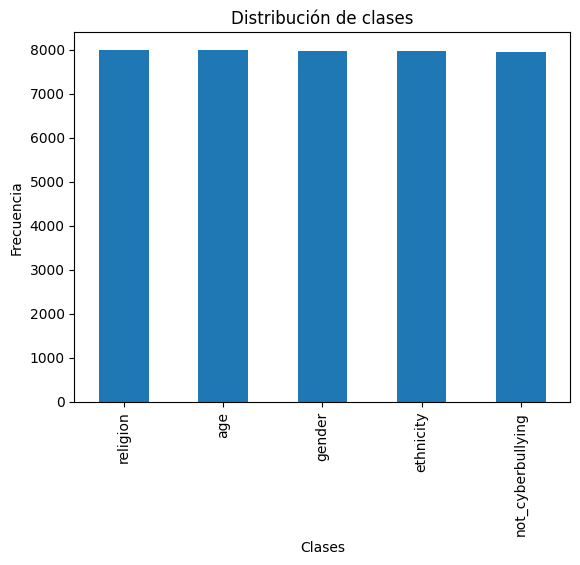

In [72]:
# Contar la frecuencia de cada valor único en la columna "cyberbullying_type"
frecuencias = data['cyberbullying_type'].value_counts()

# Mostrar los resultados
print(frecuencias)

# Visualizar la distribución de clases
class_counts = data['cyberbullying_type'].value_counts()
class_counts.plot(kind='bar')
plt.title('Distribución de clases')
plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.show()

Posteriormente, se quería observar la longitud promedio de los tweets. Para esto, almacenó la longitud de cada tweet en un arreglo y luego se graficó la distribución de la longitud de los tweets.

En este caso, la mayoría de tweets tienen una longitud menor a 280 caracteres (que es el límite de caracteres que permite Twitter). Sin embargo, se puede observar que hay algunos tweets que tienen una longitud mayor a 280 caracteres. Por tal motivo, se procedió a eliminar estos tweets para evitar problemas en el preprocesamiento de los datos.

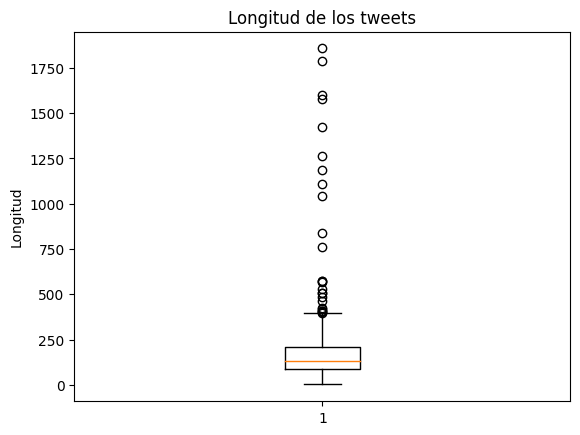

In [73]:
# Visualizar la longitud de los tweets

# Almacenar la longitud de cada tweet en una lista
lengths = [len(tweet) for tweet in data['tweet_text']]

# Crear un boxplot
plt.boxplot(lengths)
plt.title('Longitud de los tweets')
plt.ylabel('Longitud')
plt.show()

# Eliminar los tweets con longitud mayor a 280 caracteres
data = data[data['tweet_text'].map(len) <= 280]

Asimismo, se quiso determinar la presencia de **valores nulos o vacíos en el dataset**. Para ello, se utilizó la función 'isnull()' y se sumaron los valores nulos por columna. Como se puede observar, no existen valores nulos en el dataset.

<Axes: >

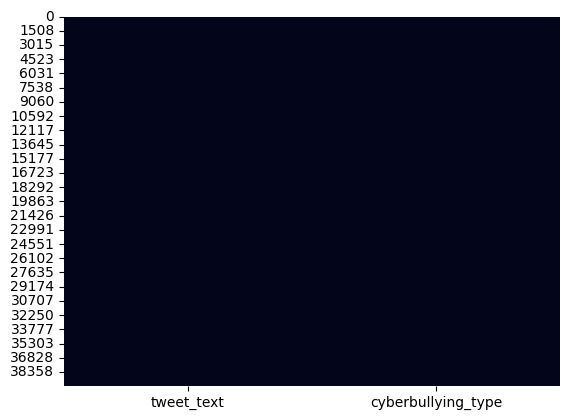

In [74]:
# Determinar valores nulos o faltantes

# Graficar heatmap de valores nulos
sns.heatmap(data.isnull(), cbar=False)

Asimismo, cabe destacar que se quiso determinar si habían **datos dupllicados**. Para ello, se utilizó la función 'duplicated()' y se sumaron los valores duplicados por columna. En este caso, s´i se encontraron datos duplicados. Por ello, se procedió a eliminarlos.

In [75]:
data['tweet_text'] = data['tweet_text'].str.lower()

#verificar datos duplicados
print("Número de datos duplicados: ", data.duplicated().sum())

#eliminar datos duplicados
data.drop_duplicates(inplace=True)

#verificar datos duplicados
print("Número de datos duplicados (post-limpieza): ", data.duplicated().sum())

Número de datos duplicados:  58
Número de datos duplicados (post-limpieza):  0


----------

##### **Preprocesamiento de Datos**

Para obtener datos más limpios se eliminaron hipervínculos, etiquetas y menciones de los comentarios. Asimismo, se eliminaron palabras vacías del idioma inglés que no aportan ninguna información relevante al modelo. En base a esto, se analizó cuáles eran las palabras más comunes en la base de datos. 

In [76]:
# Remover URLs, menciones y hashtags
new_tweets = []
new_types = []

def remove_urls_mentions_hashtags(text, type):

    text = text.lower()
    text = re.sub(r'http\S+', '', text) # URLs
    text = re.sub(r'@\S+', '', text) # Menciones
    text = re.sub(r'#\S+', ' ', text) # Hashtags
    text = re.sub('<.*?>', '', text) # HTML tags
    text = re.sub('[^a-zA-Z]', ' ', text) # Puntuación y números

    text = text.replace('rt', '')

    stemmer = PorterStemmer()
    text = text.split()
    text = [stemmer.stem(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)

    return text, type

for i in tqdm(range(len(data))):
    try:
        text, type = remove_urls_mentions_hashtags(data['tweet_text'][i], data['cyberbullying_type'][i])

        if text == '':
            continue

        new_tweets.append(text)
        new_types.append(type)
    except:
        pass

data = pd.DataFrame({
    'tweet_text': new_tweets,
    'cyberbullying_type': new_types
})

100%|██████████| 39114/39114 [00:52<00:00, 738.48it/s]


Después de haber realizado la limpieza de los tweets, se procedió a analizar **cuáles eran las palabras más comunes** en la base de datos. Para ello, se utilizó la función 'most_common()' de la librería 'collections'.

Como se puede observar, insultos y palabras ofensivas son las palabras más comunes en el dataset.

In [77]:
# Frecuencia de cada palabra
tweets = ' '.join(data['tweet_text'].values)
words = tweets.split()

frecuencia = Counter(words).most_common(10)

table = PrettyTable()
table.field_names = ['Palabra', 'Frecuencia']
for i in range(len(frecuencia)):
    table.add_row([frecuencia[i][0], frecuencia[i][1]])

print(table)


+---------+------------+
| Palabra | Frecuencia |
+---------+------------+
|  bulli  |   10117    |
|  school |    8984    |
|   fuck  |    6785    |
|   like  |    5615    |
|   joke  |    5442    |
|   girl  |    5377    |
|  nigger |    5156    |
|   high  |    5096    |
|   dumb  |    4828    |
|  muslim |    4745    |
+---------+------------+


Asimismo, se procedió a **visualizar las palabras más comunes en los tweets que representan ciberacoso**. Nuevamente, insultos y palabras ofensivas son las palabras más comunes en el dataset.

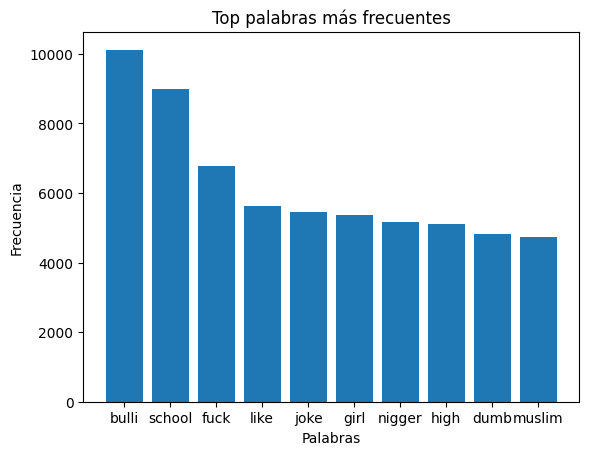

In [78]:
# Visualizar las palabras más frecuentes
plt.bar(*zip(*frecuencia))
plt.title('Top palabras más frecuentes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()

Finalmente, se prosiguió a **encodear las etiquetas de los tweets**. Para ello, se utilizó la función 'LabelEncoder()' de la librería 'sklearn'.

In [79]:
# Encodificar las clases
label_encoder = LabelEncoder()
data['cyberbullying_type'] = label_encoder.fit_transform(data['cyberbullying_type'])

# Imprimir las clases y sus respectivos códigos
print('Clases:', label_encoder.classes_)
print('Códigos:', label_encoder.transform(label_encoder.classes_))


Clases: ['age' 'ethnicity' 'gender' 'not_cyberbullying' 'religion']
Códigos: [0 1 2 3 4]


In [80]:
data.head(10)

,tweet_text,cyberbullying_type
0,word food crapilici,3
1,white,3
2,classi whore red velvet cupcak,3
3,meh p thank head concern anoth angri dude twitter,3
4,isi account pretend kurdish account like islam...,3
5,ye test god good bad indiffer weird whatev pro...,3
6,itu sekolah ya bukan tempat bulli ga jauh kaya...,3
7,karma hope bite kat butt nasti,3
8,everyth mostli priest,3
9,rebecca black drop school due bulli,3


-----------

##### **Preparación de Modelos**

Para este proyecto, se crearon 2 modelos diferentes.

El primer modelo es un modelo de **clasificación binaria**. Este modelo tiene como objetivo clasificar los tweets en 2 clases: cyberbullying y no cyberbullying. Para ello, se utilizó la columna 'cyberbullying_type' del dataset.

El segundo modelo se centra en **detectar el tipo de ciberacoso** presente, considerando la edad, género, religión y etnia como posibles categorías.


Se busca crear 2 modelos para pasarle al primero un tweet y que este nos diga si representa ciberacoso o no. En caso de que el tweet represente ciberacoso, se le pasará al segundo modelo para que nos diga qué tipo de ciberacoso es.

In [81]:
modelo1 = data.__deepcopy__()
modelo2 = data.__deepcopy__()

# Modelo 1: Cyberbullying vs. Not Cyberbullying

# Separate `not_cyberbullying` and `cyberbullying` data
not_cyberbullying = modelo1[modelo1['cyberbullying_type'] == 3]
age = modelo1[modelo1['cyberbullying_type'] == 0]
ethnicity = modelo1[modelo1['cyberbullying_type'] == 1]
gender = modelo1[modelo1['cyberbullying_type'] == 2]
religion = modelo1[modelo1['cyberbullying_type'] == 4]

sample_size = int(len(not_cyberbullying)/4)
sampled_age = age.sample(n=sample_size, replace=True, random_state=42)
sampled_gender = gender.sample(n=sample_size, replace=True, random_state=42)
sampled_religion = religion.sample(n=sample_size, replace=True, random_state=42)
sampled_ethnicity = ethnicity.sample(n=sample_size, replace=True, random_state=42)

# Combine `sampled_cyberbullying` and `not_cyberbullying` data to create a new balanced dataframe
modelo1 = pd.concat([not_cyberbullying, sampled_gender, sampled_age, sampled_ethnicity, sampled_religion])

# Remplazar label age, gender, religion, ethnicity por 1
modelo1['cyberbullying_type'] = modelo1['cyberbullying_type'].replace([0, 1, 2, 4], 1)

# Remplazar label not_cyberbullying por 0
modelo1['cyberbullying_type'] = modelo1['cyberbullying_type'].replace([3], 0)

# Contar la frecuencia de cada valor único en la columna "cyberbullying_type"
frecuencias = modelo1['cyberbullying_type'].value_counts()

# Mostrar los resultados
print("\nModelo 1: Cyberbullying vs. Not Cyberbullying\n")
print(frecuencias)


Modelo 1: Cyberbullying vs. Not Cyberbullying

cyberbullying_type
0    7740
1    7740
Name: count, dtype: int64


In [82]:
# Modelo 2: Tipos de Cyberbullying

# Separate `not_cyberbullying` and `cyberbullying` data
age = modelo2[modelo2['cyberbullying_type'] == 0]
ethnicity = modelo2[modelo2['cyberbullying_type'] == 1]
gender = modelo2[modelo2['cyberbullying_type'] == 2]
religion = modelo2[modelo2['cyberbullying_type'] == 3]

# Combine `sampled_cyberbullying` and `not_cyberbullying` data to create a new balanced dataframe
modelo2 = pd.concat([gender, age, ethnicity, religion])

# Contar la frecuencia de cada valor único en la columna "cyberbullying_type"
frecuencias = modelo2['cyberbullying_type'].value_counts()

# Mostrar los resultados
print("\nModelo 2: Cyberbullying Type\n")
print(frecuencias)


Modelo 2: Cyberbullying Type

cyberbullying_type
0    7804
2    7770
3    7740
1    7104
Name: count, dtype: int64


Con los dos datasets creados, se procedió a **dividirlos en datos de entrenamiento y datos de prueba**. Para ello, se utilizó la función 'train_test_split()' de la librería 'sklearn.model_selection'.



In [83]:
X_train_m1, X_test_m1, y_train_m1, y_test_m1 = train_test_split(modelo1['tweet_text'], modelo1['cyberbullying_type'], test_size=0.2, random_state=42)

X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(modelo2['tweet_text'], modelo2['cyberbullying_type'], test_size=0.2, random_state=42)

-----------

##### **Diseño y Entrenamiento de Modelos (LSTM)**

Como primer paso, se tokenizaron los tweets para poder alimentar los modelos LSTM. Para ello, se utilizó la función 'Tokenizer()' de la librería 'keras.preprocessing.text'.

In [84]:
# Tokenización de texto de Modelo 1
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(X_train_m1)
X_train_sequences_m1 = tokenizer1.texts_to_sequences(X_train_m1)
X_valid_sequences_m1 = tokenizer1.texts_to_sequences(X_test_m1)

# Tokenización de texto de Modelo 2
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(X_train_m2)
X_train_sequences_m2 = tokenizer2.texts_to_sequences(X_train_m2)
X_valid_sequences_m2 = tokenizer2.texts_to_sequences(X_test_m2)

Posteriormente, se secuenció y rellenó los diferentes comentarios para que todos tengan una longitud uniforme. En este caso se utilizó una longitud 200.

sequence.pad_sequences es una función de Keras que se utiliza para rellenar las secuencias. Si se pasa del largo máximo, se trunca la secuencia. Si es menor, se rellena con ceros.

In [85]:
# Padding de secuencias para que tengan la misma longitud
max_length = 280  # longitud máxima de una secuencia

X_train_m1_padded = pad_sequences(X_train_sequences_m1, maxlen=max_length)
X_valid_m1_padded = pad_sequences(X_valid_sequences_m1, maxlen=max_length)

X_train_m2_padded = pad_sequences(X_train_sequences_m2, maxlen=max_length)
X_valid_m2_padded = pad_sequences(X_valid_sequences_m2, maxlen=max_length)

Cuando ya se tenía los datos de entrenamiento y prueba, se procedió a **diseñar y entrenar el primer modelo**. Para ello, se utilizó la función 'Sequential()' de la librería 'keras.models'.

El primer modelo, como se mencionó anteriormente, es un modelo de clasificación binaria. Este modelo tiene como objetivo clasificar los tweets en 2 clases: cyberbullying y no cyberbullying. Para ello, se utilizó la columna 'cyberbullying_type' del dataset.

Asimismo, se realizó una serie de modelos LSTM con diferentes parámetros para determinar cuál era el mejor modelo. A continuación, se presentan todos los modelos que se realizaron.

In [86]:
# ---------------------- Modelo 1 - VERSION 1 ----------------------
#                CYBERBULLYING VS. NOT CYBERBULLYING

# 2 capas LSTM con 50 y 25 unidades respectivamente, DROP-OUT 0.3, L2 0.01           
# 1 capa oculta con 20 unidades, L2 0.01        (relu)                                  
# 1 capa de salida con 1 unidad, L2 0.01        (sigmoid)

# Loss: binary_crossentropy
# Optimizador: adam                                                         

# Batch size: 128                                                           
# Epochs: 5
# -----------------------------------------------------------------

# Crear modelo
model1_lstm = Sequential()
model1_lstm.add(Embedding(input_dim=len(tokenizer1.word_index)+1, output_dim=128, input_length=max_length))
model1_lstm.add(LSTM(units=50, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.01)))
model1_lstm.add(LSTM(units=25, dropout=0.3, recurrent_dropout=0.3, return_sequences=False, kernel_regularizer=l2(0.01)))
model1_lstm.add(Dense(units=20, activation='relu', kernel_regularizer=l2(0.01)))
model1_lstm.add(Dense(units=1, activation='sigmoid'))

# Compilar modelo
model1_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Entrenar modelo
model1_lstm.fit(X_train_m1_padded, y_train_m1, batch_size=128, epochs=5, validation_data=(X_valid_m1_padded, y_test_m1), callbacks=[early_stopping], verbose=0)

# Resultados de entrenamiento
loss, accuracy = model1_lstm.evaluate(X_valid_m1_padded, y_test_m1, verbose=False)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# 4 MINUTOS 53 SEGUNDOS
# ACCURACY: 0.9102067351341248

Test Loss: 0.31883862614631653, Test Accuracy: 0.9114987254142761


In [87]:
# ---------------------- Modelo 1 - VERSION 2 ----------------------
#                CYBERBULLYING VS. NOT CYBERBULLYING

# 2 capas LSTM con 64 y 32 unidades respectivamente, DROP-OUT 0.2           # SE AUMENTA LA CANTIDAD DE UNIDADES (de 50 a 64 y de 25 a 32), SE DISMINUYE EL DROP-OUT (de 0.3 a 0.2), SE ELIMINA L2
# 1 capa oculta con 16 unidades     (relu)                                  # SE DISMINUYE LA CANTIDAD DE UNIDADES (de 20 a 16), SE ELIMINA L2
# 1 capa de salida con 1 unidad     (sigmoid)

# Loss: binary_crossentropy
# Optimizador: adam

# Batch size: 256                                                           # SE AUMENTA EL BATCH SIZE (de 128 a 256)
# Epochs: 5
# -----------------------------------------------------------------

# Crear modelo
model1_lstm = Sequential()
model1_lstm.add(Embedding(input_dim=len(tokenizer1.word_index)+1, output_dim=128, input_length=max_length))
model1_lstm.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model1_lstm.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model1_lstm.add(Dense(units=16, activation='relu'))
model1_lstm.add(Dense(units=1, activation='sigmoid'))

# Compilar modelo
model1_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Entrenar modelo
model1_lstm.fit(X_train_m1_padded, y_train_m1, batch_size=256, epochs=5, validation_data=(X_valid_m1_padded, y_test_m1), callbacks=[early_stopping], verbose=0)

# Resultados de entrenamiento
loss, accuracy = model1_lstm.evaluate(X_valid_m1_padded, y_test_m1, verbose=False)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# 3 MINUTOS 49 SEGUNDOS
# ACCURACY: 0.9127907156944275

Test Loss: 0.23040001094341278, Test Accuracy: 0.9134367108345032


In [107]:
# ---------------------- Modelo 1 - VERSION 3 ----------------------
#                CYBERBULLYING VS. NOT CYBERBULLYING

# 2 capas LSTM con 128 y 64 unidades respectivamente, DROP-OUT 0.2                   
# 1 capa oculta con 32 unidades     (relu)                                          # SE AUMENTO EL NUMERO DE UNIDADES (de 16 a 32)
# 1 capa oculta con 16 unidades     (relu)                                          # SE AGREGA UNA CAPA OCULTA CON 16 UNIDADES
# 1 capa de salida con 1 unidad     (sigmoid)

# Loss: binary_crossentropy
# Optimizador: adam

# Batch size: 256                                                                   
# Epochs: 10                                                                        # SE AUMENTA EL NUMERO DE EPOCHS (de 5 a 10)
# -----------------------------------------------------------------

# Crear modelo
model1_lstm = Sequential()
model1_lstm.add(Embedding(input_dim=len(tokenizer1.word_index)+1, output_dim=128, input_length=max_length))
model1_lstm.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model1_lstm.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model1_lstm.add(Dense(units=32, activation='relu'))
model1_lstm.add(Dense(units=16, activation='relu'))
model1_lstm.add(Dense(units=1, activation='sigmoid'))

# Compilar modelo
model1_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Entrenar modelo
model1_lstm.fit(X_train_m1_padded, y_train_m1, batch_size=256, epochs=10, validation_data=(X_valid_m1_padded, y_test_m1), callbacks=[early_stopping])

# Resultados de entrenamiento
loss, accuracy = model1_lstm.evaluate(X_valid_m1_padded, y_test_m1, verbose=False)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# 6 MINUTOS 26 SEGUNDOS
# ACCURACY: 0.9169896841049194

Epoch 1/10
49/49 [==============================] - 113s 2s/step - loss: 0.4647 - accuracy: 0.7817 - val_loss: 0.2597 - val_accuracy: 0.8902
Epoch 2/10
49/49 [==============================] - 116s 2s/step - loss: 0.1950 - accuracy: 0.9283 - val_loss: 0.2282 - val_accuracy: 0.9170
Epoch 3/10
49/49 [==============================] - 118s 2s/step - loss: 0.1320 - accuracy: 0.9556 - val_loss: 0.2484 - val_accuracy: 0.9079
Epoch 4/10
49/49 [==============================] - 117s 2s/step - loss: 0.0958 - accuracy: 0.9680 - val_loss: 0.2611 - val_accuracy: 0.9102
Test Loss: 0.22820055484771729, Test Accuracy: 0.9169896841049194


El segundo modelo se centra en detectar el tipo de ciberacoso presente, considerando la edad, género, religión y etnia como posibles categorías. Para ello, se utilizó la columna 'cyberbullying_type' del dataset.

Asimismo, se realizó una serie de modelos LSTM con diferentes parámetros para determinar cuál era el mejor modelo. A continuación, se presentan todos los modelos que se realizaron.

In [91]:
# ---------------------- Modelo 2 - VERSION 1 ----------------------
#         Clasificación de texto en múltiples categorías

# 2 capas LSTM con 80 y 40 unidades respectivamente, DROP-OUT 0.3
# 1 capa oculta con 16 unidades, L2 0.01    (relu)
# 1 capa de salida con 4 unidades           (softmax)

# Loss: sparse_categorical_crossentropy
# Optimizador: adam

# Batch size: 256
# Epochs: 5
# -----------------------------------------------------------------

# Crear modelo
model2_lstm = Sequential()
model2_lstm.add(Embedding(input_dim=len(tokenizer2.word_index)+1, output_dim=128, input_length=max_length))
model2_lstm.add(LSTM(units=80, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model2_lstm.add(LSTM(units=40, dropout=0.3, recurrent_dropout=0.3))
model2_lstm.add(Dense(units=16, activation='relu', kernel_regularizer=l2(0.01)))
model2_lstm.add(Dense(units=4, activation='softmax'))

# Compilar modelo
model2_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stopping_v1 = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Entrenar modelo
model2_lstm.fit(X_train_m2_padded, y_train_m2, batch_size=256, epochs=5, validation_data=(X_valid_m2_padded, y_test_m2), callbacks=[early_stopping_v1], verbose=0)

# Resultados de entrenamiento
loss, accuracy = model2_lstm.evaluate(X_valid_m2_padded, y_test_m2, verbose=False)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# 14 MINUTOS 25 SEGUNDOS
# ACCURACY: 0.9174885153770447

Test Loss: 0.29875919222831726, Test Accuracy: 0.9174885153770447


In [92]:
# ---------------------- Modelo 2 - VERSION 2 ----------------------
#         Clasificación de texto en múltiples categorías

# 2 capas LSTM con 50 y 25 unidades respectivamente, DROP-OUT 0.4               # SE REDUCE NEURONAS (de 80 a 50 y de 40 a 25), SE AUMENTA EL DROP-OUT (de 0.3 a 0.4)
# 1 capa oculta con 16 unidades         (relu)                                  # SE ELIMINA L2 0.01
# 1 capa de salida con 4 unidades       (softmax)                                 

# Loss: sparse_categorical_crossentropy
# Optimizador: adam

# Batch size: 256
# Epochs: 5
# -----------------------------------------------------------------

# Crear modelo
model2_lstm = Sequential()
model2_lstm.add(Embedding(input_dim=len(tokenizer2.word_index)+1, output_dim=128, input_length=max_length))
model2_lstm.add(LSTM(units=50, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
model2_lstm.add(LSTM(units=25, dropout=0.4, recurrent_dropout=0.4))
model2_lstm.add(Dense(units=16, activation='relu'))
model2_lstm.add(Dense(units=4, activation='softmax'))

model2_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping_v2 = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model2_lstm.fit(X_train_m2_padded, y_train_m2, batch_size=256, epochs=5, validation_data=(X_valid_m2_padded, y_test_m2), callbacks=[early_stopping_v2], verbose=0)

# Resultados de entrenamiento
loss, accuracy = model2_lstm.evaluate(X_valid_m2_padded, y_test_m2, verbose=False)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# 8 MINUTOS 59 SEGUNDOS
# ACCURACY: 0.9248849153518677


Test Loss: 0.21915322542190552, Test Accuracy: 0.9248849153518677


In [94]:
# ---------------------- Modelo 2 - VERSION 3 ----------------------
#         Clasificación de texto en múltiples categorías

# 2 capas LSTM con 64 y 32 unidades respectivamente, DROP-OUT 0.2               # SE AUMENTA LA CANTIDAD DE UNIDADES (de 50 a 64 y de 25 a 32), SE DISMINUYE EL DROP-OUT (de 0.4 a 0.2)
# 1 capa oculta con 16 unidades         (relu)                                  
# 1 capa de salida con 4 unidades       (softmax)                                 

# Loss: sparse_categorical_crossentropy
# Optimizador: adam

# Batch size: 128                                                               # SE DISMINUYE EL BATCH SIZE (de 256 a 128)                                                               
# Epochs: 5
# -----------------------------------------------------------------

# Crear modelo
model2_lstm = Sequential()
model2_lstm.add(Embedding(input_dim=len(tokenizer2.word_index)+1, output_dim=128, input_length=max_length))
model2_lstm.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model2_lstm.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model2_lstm.add(Dense(units=16, activation='relu'))
model2_lstm.add(Dense(units=4, activation='softmax'))

# Compilar modelo
model2_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Entrenar modelo
model2_lstm.fit(X_train_m2_padded, y_train_m2, batch_size=128, epochs=5, validation_data=(X_valid_m2_padded, y_test_m2), callbacks=[early_stopping])

# Resultados de entrenamiento
loss, accuracy = model2_lstm.evaluate(X_valid_m2_padded, y_test_m2, verbose=False)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# 9 MINUTOS 47 SEGUNDOS
# ACCURACY: 0.9275147914886475

Epoch 1/5
191/191 [==============================] - 145s 746ms/step - loss: 0.5161 - accuracy: 0.8075 - val_loss: 0.2180 - val_accuracy: 0.9223
Epoch 2/5
191/191 [==============================] - 143s 750ms/step - loss: 0.1712 - accuracy: 0.9398 - val_loss: 0.2139 - val_accuracy: 0.9275
Epoch 3/5
191/191 [==============================] - 145s 760ms/step - loss: 0.1154 - accuracy: 0.9612 - val_loss: 0.2243 - val_accuracy: 0.9236
Epoch 4/5
191/191 [==============================] - 147s 772ms/step - loss: 0.0887 - accuracy: 0.9709 - val_loss: 0.2462 - val_accuracy: 0.9188
Test Loss: 0.21385058760643005, Test Accuracy: 0.9275147914886475


Finalmente, se procedió a **evaluar los modelos**. Para ello, se utilizó classification_report de la librería 'sklearn.metrics'.

In [108]:
# ---------------------- Modelo 1 ----------------------

# classification report
y_pred_m1 = model1_lstm.predict(X_valid_m1_padded)
y_pred_m1 = np.round(y_pred_m1).astype(int)

print(classification_report(y_test_m1, y_pred_m1))

97/97 [==============================] - 8s 77ms/step
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1535
           1       0.94      0.89      0.92      1561

    accuracy                           0.92      3096
   macro avg       0.92      0.92      0.92      3096
weighted avg       0.92      0.92      0.92      3096



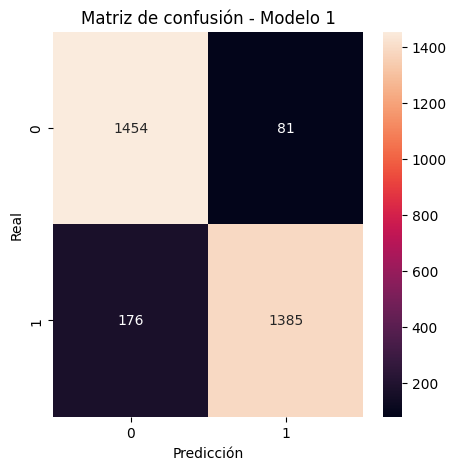

In [109]:
# MATRIZ DE CONFUSION del modelo 1
cm_m1 = confusion_matrix(y_test_m1, y_pred_m1)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_m1, annot=True, fmt="d")
plt.title('Matriz de confusión - Modelo 1')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [111]:
# ---------------------- Modelo 2 ----------------------

# classification report
y_pred_m2 = model2_lstm.predict(X_valid_m2_padded)
y_pred_m2 = np.argmax(y_pred_m2, axis=1)

print(classification_report(y_test_m2, y_pred_m2))

191/191 [==============================] - 7s 36ms/step
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1635
           1       0.99      0.97      0.98      1349
           2       0.90      0.88      0.89      1536
           3       0.84      0.91      0.87      1564

    accuracy                           0.93      6084
   macro avg       0.93      0.93      0.93      6084
weighted avg       0.93      0.93      0.93      6084



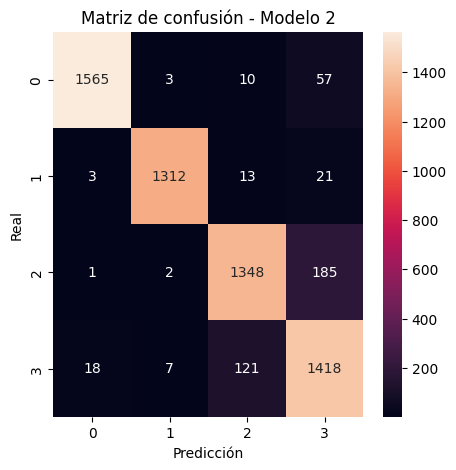

In [112]:
# MATRIZ DE CONFUSION del modelo 2
cm_m2 = confusion_matrix(y_test_m2, y_pred_m2)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_m2, annot=True, fmt="d")
plt.title('Matriz de confusión - Modelo 2')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Finalmente, se quiso evaluar en dónde era que se confundían los modelos específicamente. Para esto, se determinó qué tweets específicos se habían clasificado mal. Para ello, se utilizó la función 'predict_classes()' de la librería 'keras.models'.

In [105]:
# Generar un dataset con los tweets que el primer modelo clasificó mal. TWEET, CLASE REAL, CLASE PREDICHA

y_test_m1_array = np.array(y_test_m1)
modelo1_errores = []
for i in range(len(y_pred_m1)):
    if y_test_m1_array[i] != y_pred_m1[i][0]:

        real_class = 'cyberbullying' if y_test_m1_array[i] == 1 else 'not_cyberbullying'
        predicted_class = 'cyberbullying' if y_pred_m1[i][0] == 1 else 'not_cyberbullying'

        modelo1_errores.append([X_test_m1.iloc[i], real_class, predicted_class])

modelo1_errores = pd.DataFrame(modelo1_errores, columns = ['tweet', 'clase real', 'clase predicha'])
modelo1_errores.to_csv('modelo1_errores.csv', index = False)

modelo1_errores.head(20)

,tweet,clase real,clase predicha
0,biolog inequ,cyberbullying,not_cyberbullying
1,whoa nice uh impress celin,cyberbullying,not_cyberbullying
2,true,cyberbullying,not_cyberbullying
3,omg wait tri hard crazi eye kat amp douch bag ...,cyberbullying,not_cyberbullying
4,continu product carbon dioxid,cyberbullying,not_cyberbullying
5,one bottom pic feminazi tumblr fag,cyberbullying,not_cyberbullying
6,exactli cult death center around idea go heave...,cyberbullying,not_cyberbullying
7,drasco u chef wanka one day miss ask self fuck...,cyberbullying,not_cyberbullying
8,true scotsman,cyberbullying,not_cyberbullying
9,ahh christian conspiraci book involv real chri...,not_cyberbullying,cyberbullying


In [106]:
# Generar un dataset con los tweets que el segundo modelo clasificó mal. TWEET, CLASE REAL, CLASE PREDICHA

y_test_m2_array = np.array(y_test_m2)
modelo2_errores = []

for i in range(len(y_pred_m2)):
    if y_test_m2_array[i] != y_pred_m2[i]:
        
        real_class = ""
        if y_test_m2_array[i] == 0:
            real_class = 'age'
        elif y_test_m2_array[i] == 1:
            real_class = "ethnicity"
        elif y_test_m2_array[i] == 2:
            real_class = "gender"
        elif y_test_m2_array[i] == 3:
            real_class = "religion"

        predicted_class = ""
        if y_pred_m2[i] == 0:
            predicted_class = 'age'
        elif y_pred_m2[i] == 1:
            predicted_class = "ethnicity"
        elif y_pred_m2[i] == 2:
            predicted_class = "gender"
        elif y_pred_m2[i] == 3:
            predicted_class = "religion"

        modelo2_errores.append([X_test_m2.iloc[i], real_class, predicted_class])

modelo2_errores = pd.DataFrame(modelo2_errores, columns = ['tweet', 'clase real', 'clase predicha'])
modelo2_errores.to_csv('modelo2_errores.csv', index = False)

modelo2_errores.head(20)

,tweet,clase real,clase predicha
0,chemali special kind twit master whine rd worl...,gender,religion
1,gotta bet shiv school bulli,age,religion
2,dear mother natur wish would stop fuck shit cu...,religion,gender
3,fuck,gender,religion
4,get bulli royal high say unknow boy said shutu...,age,gender
5,femal owe mom futur daughter alway conduct sel...,religion,gender
6,fuck sake anni disgust blush enough enough,religion,gender
7,school univers landlord ask paid cash dollar b...,age,religion
8,meh myer regain form forget ever exist armia l...,gender,religion
9,school bulli go deposit cowardic po,age,religion
